C:\Users\PC\AppData\Local\Temp\ipykernel_21084\3886783595.py:46: RuntimeWarning: invalid value encountered in sqrt
  A_x = envelope / np.sqrt(alpha)
C:\Users\PC\AppData\Local\Temp\ipykernel_21084\3886783595.py:61: RuntimeWarning: invalid value encountered in divide
  psi_wkb /= np.sqrt(np.sum(np.abs(psi_wkb)**2 * dx))
C:\Users\PC\AppData\Local\Temp\ipykernel_21084\3886783595.py:101: RuntimeWarning: invalid value encountered in sqrt
  A_x_final = envelope_final / np.sqrt(alpha_final)
C:\Users\PC\AppData\Local\Temp\ipykernel_21084\3886783595.py:116: RuntimeWarning: invalid value encountered in divide
  psi_wkb_final /= np.sqrt(np.sum(np.abs(psi_wkb_final)**2 * dx))


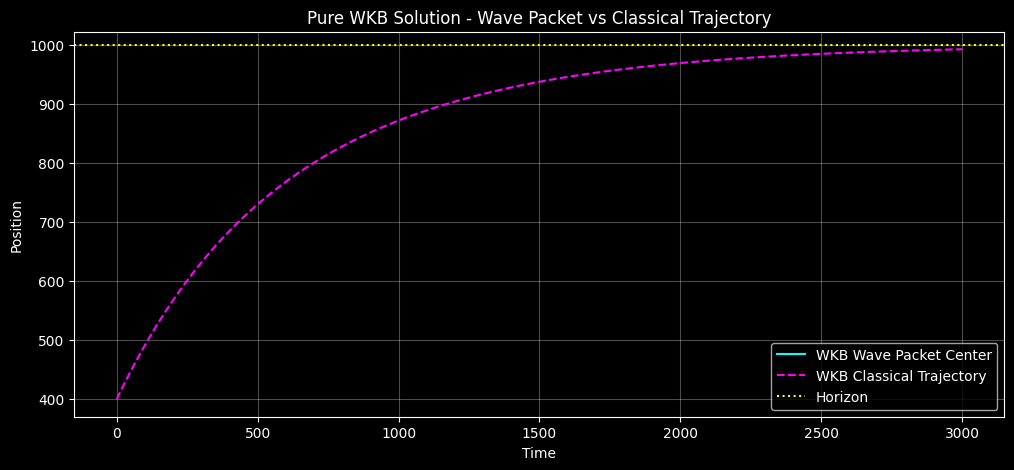

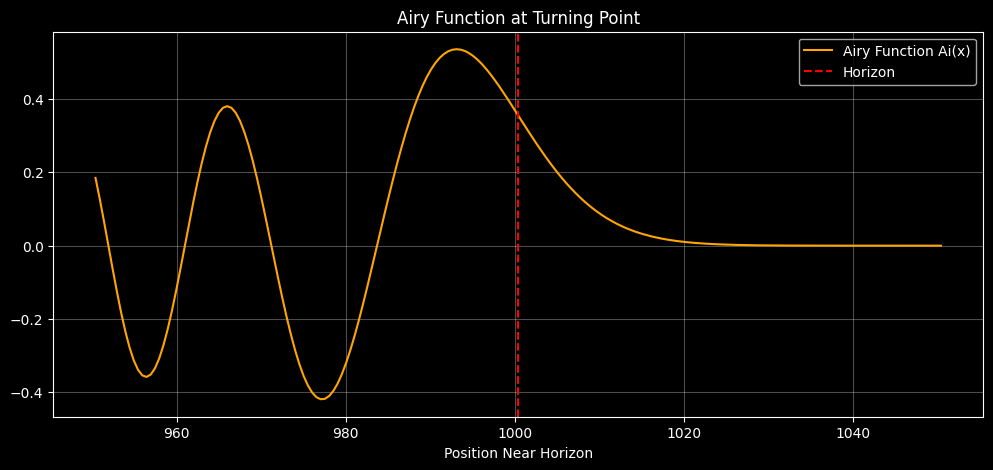

Horizon position: 1000.39
Energy E = sin(k₀) = 0.0000

WKB Formula Confirmation:
✓ Amplitude factor: 1/√(1-t(x)) = 1/√(α)
✓ Phase integral: ∫ E/(1-t(x')) dx' computed via cumsum
✓ Spinor projection: [1,1]^T/√2
✓ Time evolution: exp(-iEt/ℏ)
✓ Full formula: Ψ(x,t) = C/√(1-t(x)) * [1,1]^T/√2 * exp(i∫E/(1-t)dx') * exp(-iEt/ℏ)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import airy
plt.style.use('dark_background')

# ===== Parameters =====
L = 3000
hbar = 1
x0 = 400  # Initial packet position
k0 = 0.0  # Initial momentum
dt = 0.1
sigma = 20  # Wave packet width
frames = 30000
x = np.arange(L)
dx = 1
a = 1093  # Transition width
t_max = 2  # Max tilt

# Horizon position
x_horizon = x0 + a * np.arctanh(1 / t_max)

# Energy (conserved)
E = np.sin(k0)

# ===== Storage for results =====
time_list = []
x_c_list = []
wkb_positions = []

# ===== WKB Classical Trajectory Setup =====
current_x_wkb = x0
wkb_positions.append(current_x_wkb)

# ===== Time Evolution Loop =====
for frame in range(frames):
    current_time = frame * dt
    time_list.append(current_time)
    
    # ===== Full WKB Solution at current time =====
    # Tilt profile
    t = t_max * np.tanh((x - x0) / a)
    alpha = 1 - t
    
    # WKB amplitude with Gaussian envelope
    envelope = np.exp(-((x - x0)**2) / (2 * sigma**2))
    A_x = envelope / np.sqrt(alpha)
    
    # Phase S(x) = ∫ E / (1 - t(x')) dx'
    S = np.cumsum(E / alpha) * dx
    
    # Spatial WKB part
    psi_spatial = A_x * np.exp(1j * S / hbar)
    
    # Time evolution
    psi_temporal = np.exp(-1j * E * current_time / hbar)
    
    # Complete WKB solution
    psi_wkb = psi_spatial * psi_temporal
    
    # Normalize
    psi_wkb /= np.sqrt(np.sum(np.abs(psi_wkb)**2 * dx))
    
    # Project onto spinor [1,1]/√2
    u_upper = np.array([1, 1]) / np.sqrt(2)
    psi_spinor = np.zeros((2, len(x)), dtype=complex)
    psi_spinor[0, :] = u_upper[0] * psi_wkb
    psi_spinor[1, :] = u_upper[1] * psi_wkb
    
    # Track wave packet center
    total_density = np.abs(psi_spinor[0,:])**2 + np.abs(psi_spinor[1,:])**2
    x_c = np.sum(x * total_density) / np.sum(total_density)
    x_c_list.append(x_c)
    
    # ===== WKB Classical Trajectory =====
    if frame > 0:  # Skip first frame since we already have x0
        t_current = t_max * np.tanh((current_x_wkb - x0) / a)
        alpha_current = 1 - t_current
        
        if np.abs(alpha_current) > 1e-10 and np.abs(E / alpha_current) <= 1:
            k_wkb = np.arcsin(E / alpha_current)
            v_g = np.cos(k_wkb) * alpha_current
        else:
            v_g = 0
        
        current_x_wkb += v_g * dt
    
    wkb_positions.append(current_x_wkb)

# Trim last position to match time_list length
wkb_positions = np.array(wkb_positions[:-1])

# ===== Final WKB Solution =====
final_time = frames * dt

# Tilt profile for final time
t_final = t_max * np.tanh((x - x0) / a)
alpha_final = 1 - t_final

# WKB amplitude with Gaussian envelope
envelope_final = np.exp(-((x - x0)**2) / (2 * sigma**2))
A_x_final = envelope_final / np.sqrt(alpha_final)

# Phase S(x) = ∫ E / (1 - t(x')) dx'
S_final = np.cumsum(E / alpha_final) * dx

# Spatial WKB part
psi_spatial_final = A_x_final * np.exp(1j * S_final / hbar)

# Time evolution
psi_temporal_final = np.exp(-1j * E * final_time / hbar)

# Complete WKB solution
psi_wkb_final = psi_spatial_final * psi_temporal_final

# Normalize
psi_wkb_final /= np.sqrt(np.sum(np.abs(psi_wkb_final)**2 * dx))

# Project onto spinor [1,1]/√2
psi_final = np.zeros((2, len(x)), dtype=complex)
psi_final[0, :] = u_upper[0] * psi_wkb_final
psi_final[1, :] = u_upper[1] * psi_wkb_final

# ===== Airy Function Near Horizon =====
dt_dx_horizon = (t_max / a) * (1 - (1/t_max)**2)
ell = (2 * abs(dt_dx_horizon))**(-1/3)
x_airy = np.linspace(x_horizon - 50, x_horizon + 50, 200)
xi = (x_airy - x_horizon) / ell
Ai, _, _, _ = airy(xi)

# ===== Plot Results =====
# Plot 1: Pure WKB Trajectory
plt.figure(figsize=(12, 5))
plt.plot(time_list, x_c_list, 'cyan', label="WKB Wave Packet Center")
plt.plot(time_list, wkb_positions, 'magenta', linestyle='--', label="WKB Classical Trajectory")
plt.axhline(y=x_horizon, color='yellow', linestyle=':', label="Horizon")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Pure WKB Solution - Wave Packet vs Classical Trajectory")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot 2: Airy Function Near Horizon
plt.figure(figsize=(12, 5))
plt.plot(x_airy, Ai, 'orange', label="Airy Function Ai(x)")
plt.axvline(x_horizon, color='red', linestyle='--', label="Horizon")
plt.xlabel("Position Near Horizon")
plt.title("Airy Function at Turning Point")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Horizon position: {x_horizon:.2f}")
print(f"Energy E = sin(k₀) = {E:.4f}")

# Print confirmation of WKB formula usage
print(f"\nWKB Formula Confirmation:")
print(f"✓ Amplitude factor: 1/√(1-t(x)) = 1/√(α)")
print(f"✓ Phase integral: ∫ E/(1-t(x')) dx' computed via cumsum")
print(f"✓ Spinor projection: [1,1]^T/√2")
print(f"✓ Time evolution: exp(-iEt/ℏ)")
print(f"✓ Full formula: Ψ(x,t) = C/√(1-t(x)) * [1,1]^T/√2 * exp(i∫E/(1-t)dx') * exp(-iEt/ℏ)")